<a href="https://colab.research.google.com/github/a4aakash/Computer-Vision/blob/master/Image_stagenography_using_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb

     |████████████████████████████████| 1.8MB 5.2MB/s 
     |████████████████████████████████| 133kB 53.6MB/s 
     |████████████████████████████████| 174kB 48.0MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=11d4f8331e5aa8282234bb78f206fb797c2c53180e634bfd174cdbaca6fbae3f
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=43e220f21d586ddafa6f43e4c8e9f5c453c6941ae55fe5f137a256a61544e860
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [2]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2021-05-15 14:10:54--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  5.45MB/s    in 35s     

2021-05-15 14:11:29 (6.73 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [3]:
!unzip /content/tiny-imagenet-200.zip

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

In [4]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.engine.topology import Network
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [5]:
### Constants ###
DATA_DIR = "./tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)


In [6]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []
    
    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
    
    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)


In [7]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 2000
Number of test examples = 2000
X_train shape: (2000, 64, 64, 3)


In [8]:
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

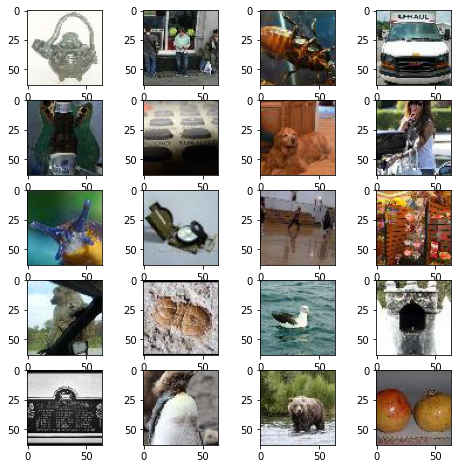

In [9]:

# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [10]:
import wandb
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]
    
    s_loss = rev_loss(s_true, s_pred)
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x = concatenate([input_C, x])
    
    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='selu', name='output_C')(x)
    
    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='selu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='selu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='selu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='selu', name='output_S')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Network(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False
    
    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)
    
    return encoder, decoder, autoencoder
 

In [11]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 300:
        return 0.0003

In [12]:
import wandb
wandb.init(project='stenography')
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'rev_loss',
      'goal': 'minimize'   
    },
    'parameters': {

        'lr':{
            'values':[0.001]
        },
        'activation':{
            'values':['relu']
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: oq6fmndi
Sweep URL: https://wandb.ai/avv/uncategorized/sweeps/oq6fmndi


In [13]:
def train(e,lr):
    
  wandb.init(project='stenography_tf',name='selu'+str(lr)+str(e))
  print(wandb.config)
  NB_EPOCHS = e
  BATCH_SIZE = 32
  encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])
  K.set_value(autoencoder_model.optimizer.lr,lr)
  K.set_value(reveal_model.optimizer.lr,lr)
  m = input_S.shape[0]
  loss_history = []
  for epoch in range(NB_EPOCHS):
      np.random.shuffle(input_S)
      np.random.shuffle(input_C)
      t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)

      ae_loss = []
      rev_loss = []
      cover_imgs=[]
      secret_imgs=[]
      encoded_secrets=[]
      decoded_secrets=[]
      diff_ss=[]
      diff_cc=[]
      for idx in t:
          
          batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
          batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
          
          C_prime = encoder_model.predict([batch_S, batch_C])
          aeLoss = autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                    y=np.concatenate((batch_S, batch_C),axis=3))
          
          ae_loss.append(aeLoss)

          revLoss = reveal_model.train_on_batch(x=C_prime,
                                                y=batch_S)
          rev_loss.append(revLoss)
          wandb.log({"ae_loss":aeLoss})

          
          t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss)))
      
      mean_ae_loss = np.mean(ae_loss)
      wandb.log({"mean_ae_loss":mean_ae_loss})

      loss_history.append(mean_ae_loss)
      print(len(loss_history))
      if (epoch+1)%40==0:
        # Retrieve decoded predictions.
        decoded = autoencoder_model.predict([input_S, input_C])
        decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

        # Get absolute difference between the outputs and the expected values.
        diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

        # Configs for results display

        # Show images in gray scale
        SHOW_GRAY = False
        # Show difference bettwen predictions and ground truth.
        SHOW_DIFF = True

        # Diff enhance magnitude
        ENHANCE = 1

        # Number of secret and cover pairs to show.
        n = 6

        def rgb2gray(rgb):
            return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

        def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
            ax = plt.subplot(n_rows, n_col, idx)
            if gray:
                plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
            else:
                plt.imshow(img)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if first_row:
                plt.title(title)

        fig = plt.figure(figsize=(14, 15))
        rand_indx = [random.randint(0, 999) for x in range(n)]
        # for i, idx in enumerate(range(0, n)):
        for i, idx in enumerate(rand_indx):
            n_col = 6 if SHOW_DIFF else 4
            cover = input_C[idx]
            show_image(cover, n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')
            cover_imgs.append(cover)
            #wandb.log({"Cover":wandb.Image(input_C[idx])})

            secret = input_S[idx]
            show_image(secret, n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')
            secret_imgs.append(secret)
            #wandb.log({"Secret":wandb.Image(input_S[idx])})
            
            encoded_secret = decoded_C[idx]
            show_image(encoded_secret, n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')
            encoded_secrets.append(encoded_secret)
            #wandb.log({"Encoded Secret":wandb.Image(decoded_C[idx])})
            
            decoded_secret = decoded_S[idx]
            show_image(decoded_secret, n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')
            decoded_secrets.append(decoded_secret)
            #wandb.log({"Decoded Cover":wandb.Image(decoded_S[idx])})
            
            
            if SHOW_DIFF:
                diff_c = np.multiply(diff_C[idx], ENHANCE)
                show_image(diff_c, n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
                diff_cc.append(diff_c)
                #wandb.log({"Diff Cover":wandb.Image(diff_C[idx])})
                
                diff_s = np.multiply(diff_S[idx], ENHANCE)
                show_image(diff_s, n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')
                diff_ss.append(diff_s)
                #wandb.log({"Diff Secret":wandb.Image(diff_S[idx])})

        # Now we can save it to a numpy array.
        plt.savefig('output.png')

        plt.show()
        wandb.log({"Output":wandb.Image('output.png')})
        


        




       
  plt.plot(loss_history)

  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.show()



{}


Epoch 1 | Batch: 992 of 1000. Loss AE 3050434.31 | Loss Rev 1323852.74: 100%|██████████| 32/32 [00:51<00:00,  1.60s/it]
  0%|          | 0/32 [00:00<?, ?it/s]

1


Epoch 2 | Batch: 992 of 1000. Loss AE 1396730.45 | Loss Rev   88414.80: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

2


Epoch 3 | Batch: 992 of 1000. Loss AE 1298565.71 | Loss Rev   31291.43: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

3


Epoch 4 | Batch: 992 of 1000. Loss AE 1376858.28 | Loss Rev   80600.00: 100%|██████████| 32/32 [00:13<00:00,  2.36it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

4


Epoch 5 | Batch: 992 of 1000. Loss AE 1308975.17 | Loss Rev   37132.13: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

5


Epoch 6 | Batch: 992 of 1000. Loss AE 1640797.40 | Loss Rev  414866.43: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

6


Epoch 7 | Batch: 992 of 1000. Loss AE 1369992.82 | Loss Rev   87381.66: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

7


Epoch 8 | Batch: 992 of 1000. Loss AE 1290620.49 | Loss Rev   31731.03: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

8


Epoch 9 | Batch: 992 of 1000. Loss AE 1345512.93 | Loss Rev  169882.58: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

9


Epoch 10 | Batch: 992 of 1000. Loss AE 2420457.39 | Loss Rev 1119219.23: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

10


Epoch 11 | Batch: 992 of 1000. Loss AE 1912417.37 | Loss Rev  181939.01: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

11


Epoch 12 | Batch: 992 of 1000. Loss AE 1912490.30 | Loss Rev   39714.80: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

12


Epoch 13 | Batch: 992 of 1000. Loss AE 1898715.52 | Loss Rev   31187.39: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

13


Epoch 14 | Batch: 992 of 1000. Loss AE 1882573.92 | Loss Rev   31136.52: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

14


Epoch 15 | Batch: 992 of 1000. Loss AE 2169026.99 | Loss Rev   59122.99: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

15


Epoch 16 | Batch: 992 of 1000. Loss AE 1920354.32 | Loss Rev   30991.92: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

16


Epoch 17 | Batch: 992 of 1000. Loss AE 1919707.36 | Loss Rev   30521.64: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

17


Epoch 18 | Batch: 992 of 1000. Loss AE 1920011.57 | Loss Rev   30912.72: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

18


Epoch 19 | Batch: 992 of 1000. Loss AE 1917625.68 | Loss Rev   30424.97: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

19


Epoch 20 | Batch: 992 of 1000. Loss AE 1903634.29 | Loss Rev   30471.42: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

20


Epoch 21 | Batch: 992 of 1000. Loss AE 1886844.02 | Loss Rev   30455.23: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

21


Epoch 22 | Batch: 992 of 1000. Loss AE 1883127.95 | Loss Rev   30302.72: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

22


Epoch 23 | Batch: 992 of 1000. Loss AE 1876830.90 | Loss Rev   30287.28: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

23


Epoch 24 | Batch: 992 of 1000. Loss AE 1874924.93 | Loss Rev   30288.06: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

24


Epoch 25 | Batch: 992 of 1000. Loss AE 1873660.19 | Loss Rev   29817.16: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

25


Epoch 26 | Batch: 992 of 1000. Loss AE 1873557.76 | Loss Rev   29956.93: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

26


Epoch 27 | Batch: 992 of 1000. Loss AE 1873355.73 | Loss Rev   29944.38: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

27


Epoch 28 | Batch: 992 of 1000. Loss AE 1873570.51 | Loss Rev   30418.19: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

28


Epoch 29 | Batch: 992 of 1000. Loss AE 1872821.98 | Loss Rev   29825.33: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

29


Epoch 30 | Batch: 992 of 1000. Loss AE 1872645.23 | Loss Rev   29778.27: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

30


Epoch 31 | Batch: 992 of 1000. Loss AE 1873052.34 | Loss Rev   30380.78: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

31


Epoch 32 | Batch: 992 of 1000. Loss AE 1872921.40 | Loss Rev   30335.11: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

32


Epoch 33 | Batch: 992 of 1000. Loss AE 1873250.99 | Loss Rev   30772.88: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

33


Epoch 34 | Batch: 992 of 1000. Loss AE 1873312.21 | Loss Rev   30837.33: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

34


Epoch 35 | Batch: 992 of 1000. Loss AE 1871617.41 | Loss Rev   29278.25: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

35


Epoch 36 | Batch: 992 of 1000. Loss AE 1871638.48 | Loss Rev   29339.57: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

36


Epoch 37 | Batch: 992 of 1000. Loss AE 1871713.04 | Loss Rev   29509.21: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

37


Epoch 38 | Batch: 992 of 1000. Loss AE 1872088.04 | Loss Rev   30001.67: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

38


Epoch 39 | Batch: 992 of 1000. Loss AE 1880336.35 | Loss Rev   31274.48: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

39


Epoch 40 | Batch: 992 of 1000. Loss AE 1920602.05 | Loss Rev   31379.79: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s]


40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

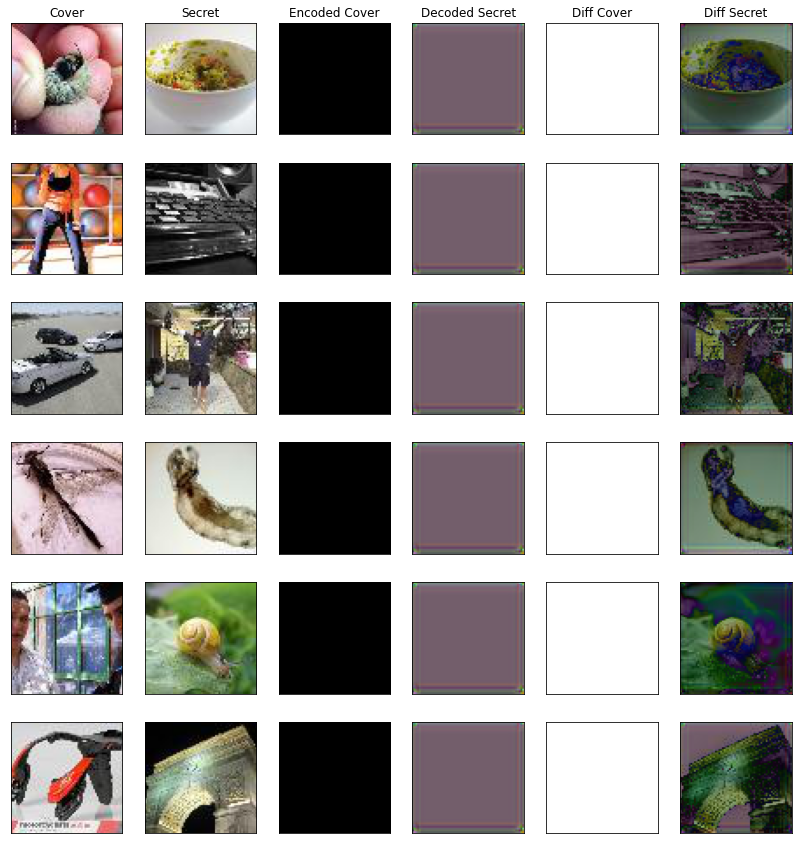

Epoch 41 | Batch: 992 of 1000. Loss AE 1919467.44 | Loss Rev   29925.17: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

41


Epoch 42 | Batch: 992 of 1000. Loss AE 1919510.11 | Loss Rev   29992.06: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

42


Epoch 43 | Batch: 992 of 1000. Loss AE 1919376.40 | Loss Rev   29887.39: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

43


Epoch 44 | Batch: 992 of 1000. Loss AE 1919582.69 | Loss Rev   30106.45: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

44


Epoch 45 | Batch: 992 of 1000. Loss AE 1919515.20 | Loss Rev   30042.55: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

45


Epoch 46 | Batch: 992 of 1000. Loss AE 1919339.28 | Loss Rev   29869.12: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

46


Epoch 47 | Batch: 992 of 1000. Loss AE 1919709.63 | Loss Rev   30242.17: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

47


Epoch 48 | Batch: 992 of 1000. Loss AE 1919647.75 | Loss Rev   30180.28: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

48


Epoch 49 | Batch: 992 of 1000. Loss AE 1919276.19 | Loss Rev   29811.67: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

49


Epoch 50 | Batch: 992 of 1000. Loss AE 1919090.82 | Loss Rev   29628.57: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

50


Epoch 51 | Batch: 992 of 1000. Loss AE 1919351.00 | Loss Rev   29889.21: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

51


Epoch 52 | Batch: 992 of 1000. Loss AE 1920685.68 | Loss Rev   31225.69: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

52


Epoch 53 | Batch: 992 of 1000. Loss AE 1920803.11 | Loss Rev   31345.74: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

53


Epoch 54 | Batch: 992 of 1000. Loss AE 1919669.72 | Loss Rev   30215.09: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

54


Epoch 55 | Batch: 992 of 1000. Loss AE 1919791.51 | Loss Rev   30343.21: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

55


Epoch 56 | Batch: 992 of 1000. Loss AE 1919058.17 | Loss Rev   29945.76: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

56


Epoch 57 | Batch: 992 of 1000. Loss AE 1917552.36 | Loss Rev   31149.91: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

57


Epoch 58 | Batch: 992 of 1000. Loss AE 1920813.42 | Loss Rev   31538.96: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

58


Epoch 59 | Batch: 992 of 1000. Loss AE 1914661.37 | Loss Rev   29434.26: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

59


Epoch 60 | Batch: 992 of 1000. Loss AE 1911407.59 | Loss Rev   30172.58: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

60


Epoch 61 | Batch: 992 of 1000. Loss AE 1912315.45 | Loss Rev   30471.66: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

61


Epoch 62 | Batch: 992 of 1000. Loss AE 1909882.05 | Loss Rev   29525.29: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

62


Epoch 63 | Batch: 992 of 1000. Loss AE 1910520.03 | Loss Rev   30406.90: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

63


Epoch 64 | Batch: 992 of 1000. Loss AE 1910577.98 | Loss Rev   30504.62: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

64


Epoch 65 | Batch: 992 of 1000. Loss AE 1909892.01 | Loss Rev   29879.77: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

65


Epoch 66 | Batch: 992 of 1000. Loss AE 1909929.51 | Loss Rev   29857.24: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

66


Epoch 67 | Batch: 992 of 1000. Loss AE 1910002.56 | Loss Rev   29985.73: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

67


Epoch 68 | Batch: 992 of 1000. Loss AE 1910383.79 | Loss Rev   30261.64: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

68


Epoch 69 | Batch: 992 of 1000. Loss AE 1910286.52 | Loss Rev   30247.29: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

69


Epoch 70 | Batch: 992 of 1000. Loss AE 1909493.38 | Loss Rev   29536.07: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

70


Epoch 71 | Batch: 992 of 1000. Loss AE 1909319.87 | Loss Rev   29384.40: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

71


Epoch 72 | Batch: 992 of 1000. Loss AE 1909972.46 | Loss Rev   29974.61: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

72


Epoch 73 | Batch: 992 of 1000. Loss AE 1910135.95 | Loss Rev   30082.83: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

73


Epoch 74 | Batch: 992 of 1000. Loss AE 1909892.62 | Loss Rev   29970.08: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

74


Epoch 75 | Batch: 992 of 1000. Loss AE 1910039.56 | Loss Rev   30105.09: 100%|██████████| 32/32 [00:14<00:00,  2.29it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

75


Epoch 76 | Batch: 992 of 1000. Loss AE 1910023.70 | Loss Rev   30009.51: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

76


Epoch 77 | Batch: 992 of 1000. Loss AE 1909204.98 | Loss Rev   29269.28: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

77


Epoch 78 | Batch: 992 of 1000. Loss AE 1909488.44 | Loss Rev   29540.91: 100%|██████████| 32/32 [00:14<00:00,  2.28it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

78


Epoch 79 | Batch: 992 of 1000. Loss AE 1905823.16 | Loss Rev   29354.97: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]
  0%|          | 0/32 [00:00<?, ?it/s]

79


Epoch 80 | Batch: 992 of 1000. Loss AE 1914990.62 | Loss Rev   32605.63: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s]


80


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

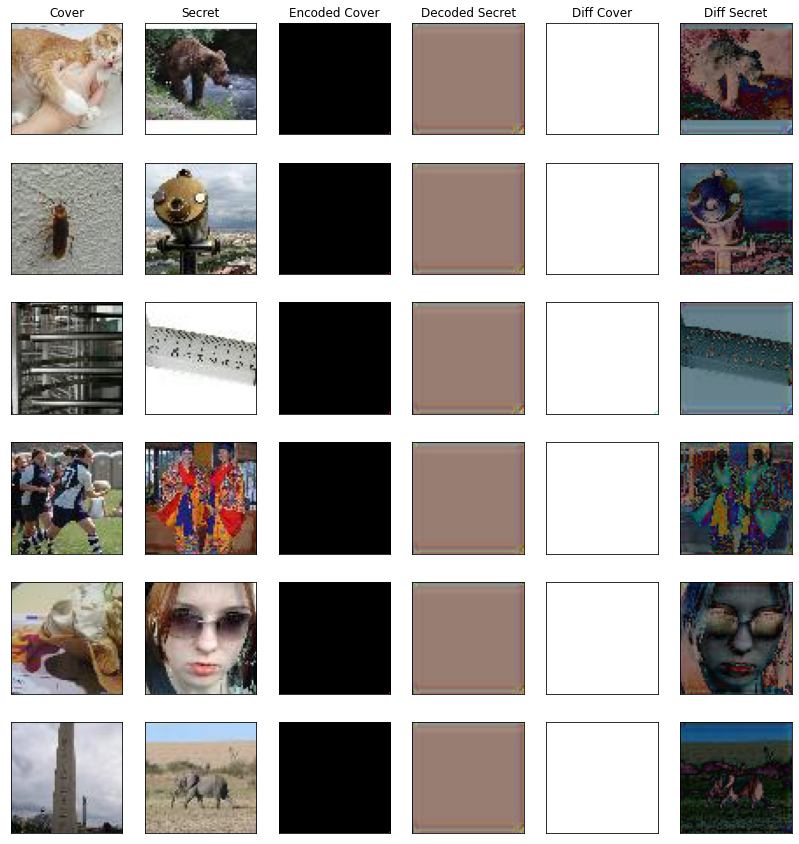

Epoch 81 | Batch: 640 of 1000. Loss AE 1963838.44 | Loss Rev   31091.26:  66%|██████▌   | 21/32 [00:09<00:05,  2.20it/s]

In [ ]:
train(300,0.001)
train(600,0.001)
train(600,0.005)

In [ ]:
import wandb
api = wandb.Api()
run = api.run("authors/stenography_tf/2ybrkdyp")
run.config["lr"] = 0.001
run.config["epochs"] = 300
run.config['activation'] = 'tanh'
run.update()